<h1>Time to Peak Biomarkers in Lung MRI Imaging </h1>
<h3>Dataset: 12 phase registered image </h3>

In [1]:
%matplotlib notebook
import numpy as np
import nibabel as nib
import sigpy.plot as pl
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import find_peaks, peak_widths
from numpy.polynomial.polynomial import Polynomial

<h1>Loading the data...<h1>

In [2]:
#Load registered image
registered = nib.load("result_nomask.nii")
registered = np.array(registered.dataobj)

<IPython.core.display.Javascript object>


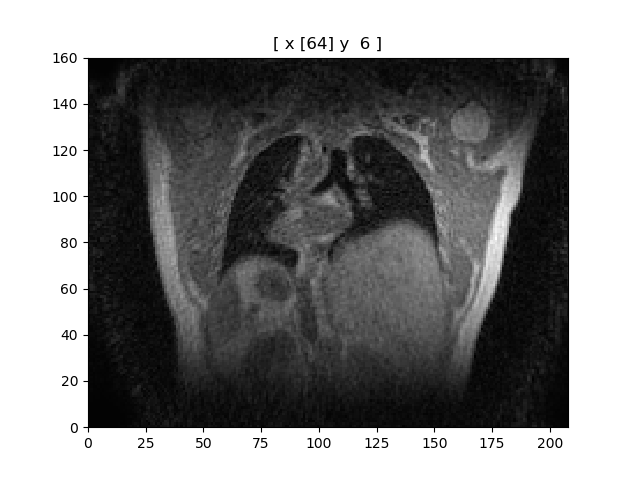

In [3]:
#Plot registered image
pl.ImagePlot(registered, x=0)

In [4]:
#Load lung mask 
mask = nib.load("lung_mask_close.nii")
mask = np.array(mask.dataobj)

<IPython.core.display.Javascript object>


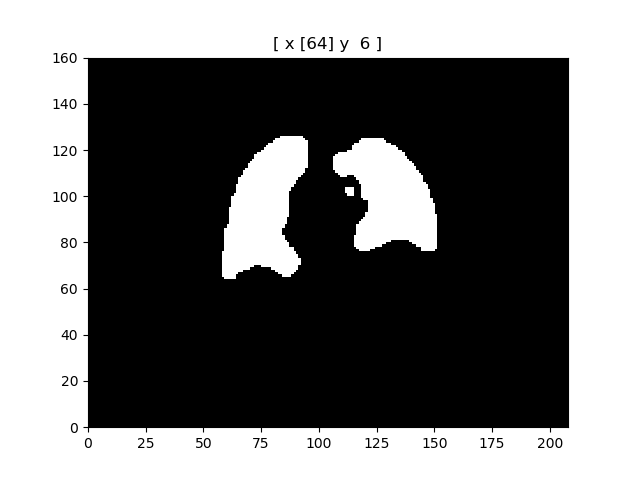

In [5]:
#Plot lung mask
pl.ImagePlot(mask, x=0)

<IPython.core.display.Javascript object>


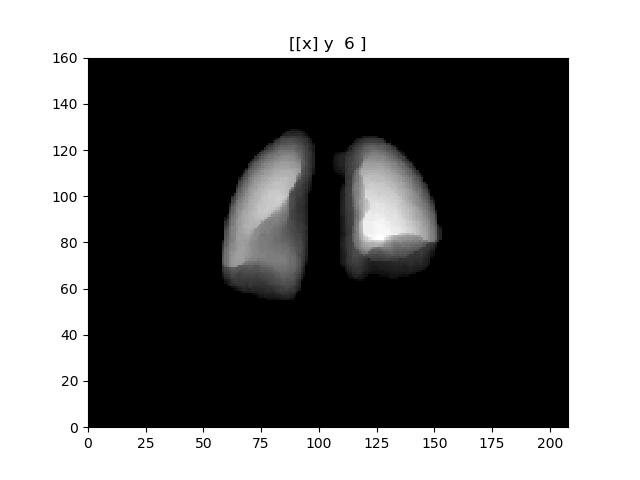

In [6]:
#Plot lung mask image in '3D'
pl.ImagePlot(np.mean(mask, axis=1), mode='r', x=0)

<h1>Lung Mask Voxel Sample<h1>

In [7]:
#Multiply lung mask with registered image 
registered_mask = np.empty((208, 128, 160, 12))
for i in range(12):
    registered_mask[:,:,:,i] = np.multiply(registered[:,:,:,i], mask[:,:,:,i])

In [8]:
#Rearange the lung respiration phases to: inspiration, exhalation, then inspiration
registered_mask = np.append(registered_mask[:,:,:,6:], (registered_mask[:,:,:,:6]), axis=3)

<IPython.core.display.Javascript object>


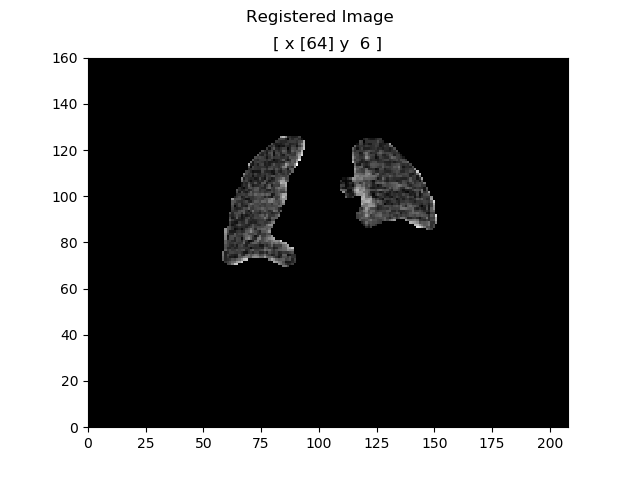

In [9]:
#Plot registered lung mask image
pl.ImagePlot(registered_mask, x=0, title='Registered Image')

In [10]:
#Remove unwanted pixels around the edge of registered lung image
#TODO Define thresholds for each time phase. Experiment with 0.00005-0.0007. Look into percentiles, like 95th. 
registered_mask = np.where(registered_mask < 0.00005, registered_mask, 0)

<IPython.core.display.Javascript object>


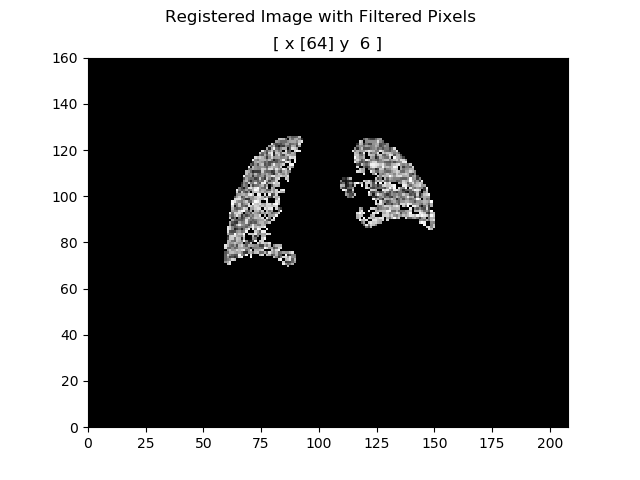

In [11]:
pl.ImagePlot(registered_mask, x=0, title='Registered Image with Filtered Pixels')

In [12]:
#Generate a voxel sample given a size 
def voxel_sample(img, voxel_size):
    size = voxel_size
    x = img.shape[0] // size
    y = img.shape[1] // size
    z = img.shape[2] // size
    t = img.shape[3]
    sample = np.empty((x,y,z,t))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                for l in range(t):
                    sample[i, j, k, l] = np.mean(img[i*size:(i+1)*size, j*size:(j+1)*size, k*size:(k+1)*size, l:l+1])
    return sample

In [13]:
#Generate a voxel sample given a size 
#TODO Create algorithm that throws out 0 values
def voxel_sample_filter(img, voxel_size):
    size = voxel_size
    x = img.shape[0] // size
    y = img.shape[1] // size
    z = img.shape[2] // size
    t = img.shape[3]
    sample = np.empty((x,y,z,t))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                for l in range(t):
                    sample_slice = img[i*size:(i+1)*size, j*size:(j+1)*size, k*size:(k+1)*size, l:l+1]
#                     sample_filtered = filter(lambda x: x < 0.0001, sample_slice)
                    sample_filtered = sample_slice[sample_slice < 0.0001]
                    sample[i, j, k, l] = np.mean(sample_filtered)
    return sample

In [14]:
#Calculate 4, 2 voxel sample filtered
#voxel_sample_filter_4 = voxel_sample_filter(registered_mask, 4)
#voxel_sample_filter_2 = voxel_sample_filter(registered_mask, 2)

In [15]:
#Calculate 4, 2 voxel sample
voxel_sample_4 = voxel_sample(registered_mask, 4)
voxel_sample_2 = voxel_sample(registered_mask, 2)

<IPython.core.display.Javascript object>


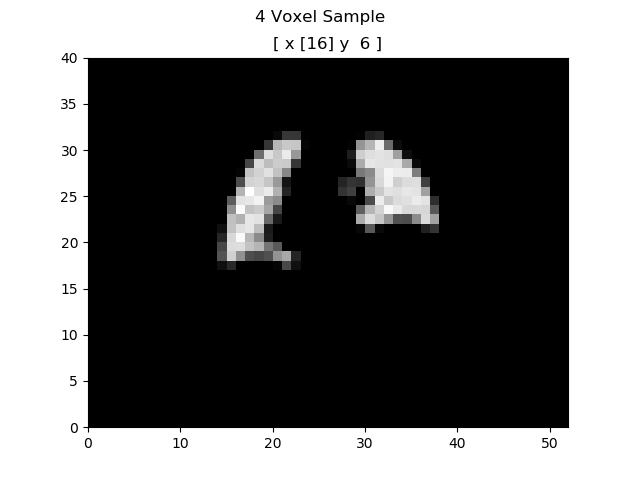

In [16]:
#Plot 4x4x4 voxel sample image
pl.ImagePlot(voxel_sample_4, x=0, title='4 Voxel Sample')

<IPython.core.display.Javascript object>


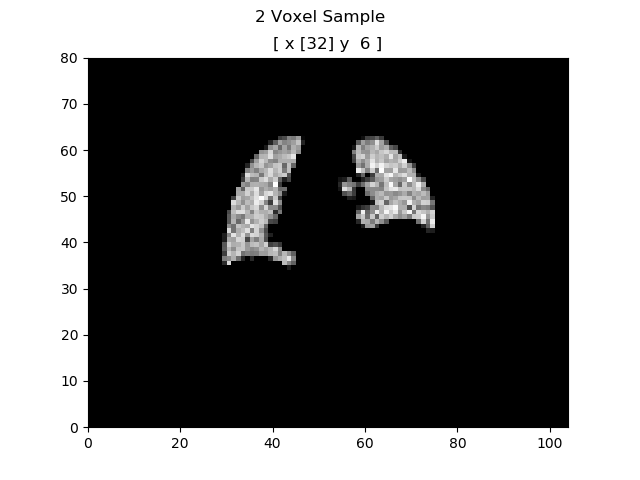

In [17]:
#Plot 2x2x2 voxel sample image
pl.ImagePlot(voxel_sample_2, x=0, title='2 Voxel Sample')

<h1> Time to Peak with 3rd Degree Polynomial Curve Fitting <h1>

In [18]:
#Plot intensity with 3rd degree polyonimal curve fit
def plot_third_degree_poly_curve_fit(intensity_values):
    poly_x, poly_y = third_degree_poly_curve_fitting(intensity_values, 40)
    fig = plt.figure()
    #Calculate TTP marker 
    ttp_marker_x = poly_x[np.argmax(poly_y)]
    ttp_marker_y = max(poly_y)
    plt.plot(np.arange(12), intensity_values, 'o', label='Intensity')
    plt.plot(poly_x, poly_y, label='3rd Degree Polynomial')
    plt.plot(ttp_marker_x, ttp_marker_y, "x", label='Max')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [19]:
#Computes 3rd degree polynomial values in [0,11]
def third_degree_poly_curve_fitting(y_values, samples):
    x_axis = np.linspace(0,11,12)
    poly_x_axis = np.linspace(0,11,num=samples)    
    poly_fit_function = np.poly1d(np.polyfit(x_axis, y_values, 3))
    
    return poly_x_axis, poly_fit_function(poly_x_axis)

In [20]:
#Calculates time to peak for 3rd degree polynomial curve fitting
def calculate_time_to_peak_third_degree_poly(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))
    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    data = img[i, j, k, :]
                    fitted_x, fitted_y = third_degree_poly_curve_fitting(data, 20)

                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

In [21]:
#Calculate time to peak with 3rd degree polynomial for a 4 voxel sample
time_to_peak_third_degree_poly_4 = calculate_time_to_peak_third_degree_poly(voxel_sample_4)

<IPython.core.display.Javascript object>


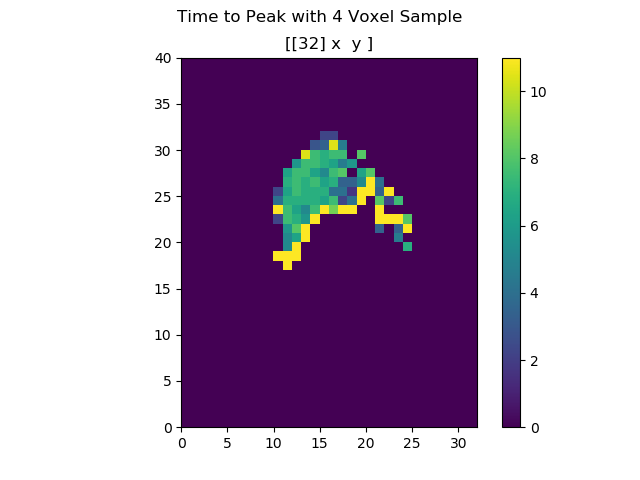

In [22]:
pl.ImagePlot(time_to_peak_third_degree_poly_4, x=0, y=2, colormap ='viridis', title='Time to Peak with 4 Voxel Sample')

<IPython.core.display.Javascript object>


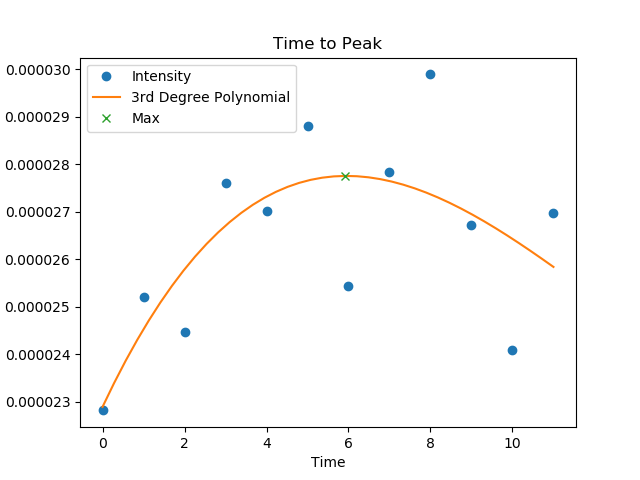

In [23]:
#Sample in the top of the left lung
plot_third_degree_poly_curve_fit(voxel_sample_4[20,16,28,:])

<IPython.core.display.Javascript object>


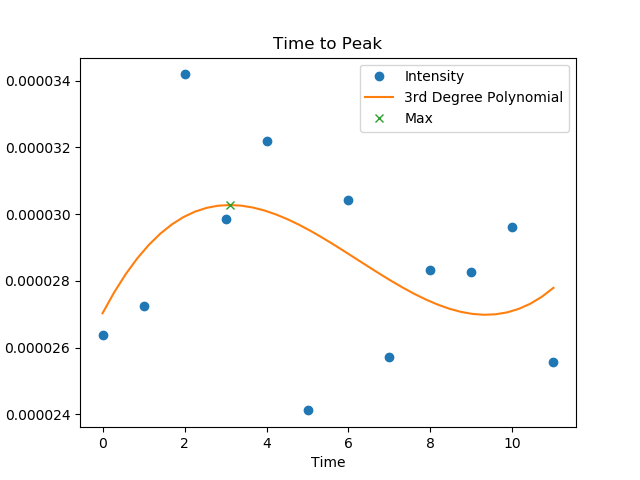

In [24]:
#Sample in the middle of the left lung
plot_third_degree_poly_curve_fit(voxel_sample_4[18,16,24,:])

<IPython.core.display.Javascript object>


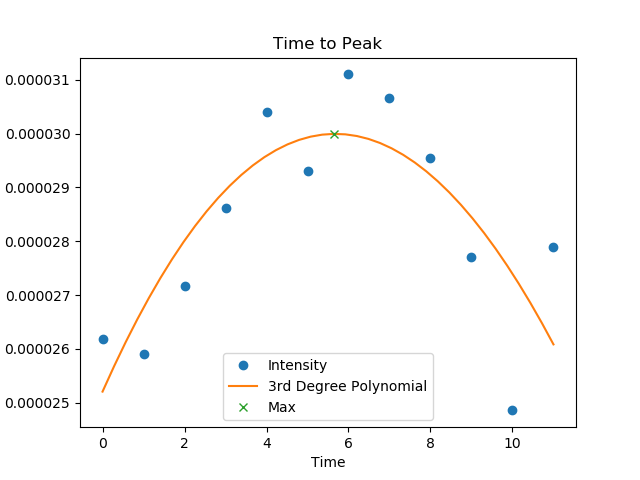

In [25]:
#Sample in the bottom of the left lung
plot_third_degree_poly_curve_fit(voxel_sample_4[16,16,20,:])

In [26]:
#Calculate time to peak with 3rd degree polynomial for registered lung mask
time_to_peak_third_degree_poly_2 = calculate_time_to_peak_third_degree_poly(voxel_sample_2)

<IPython.core.display.Javascript object>


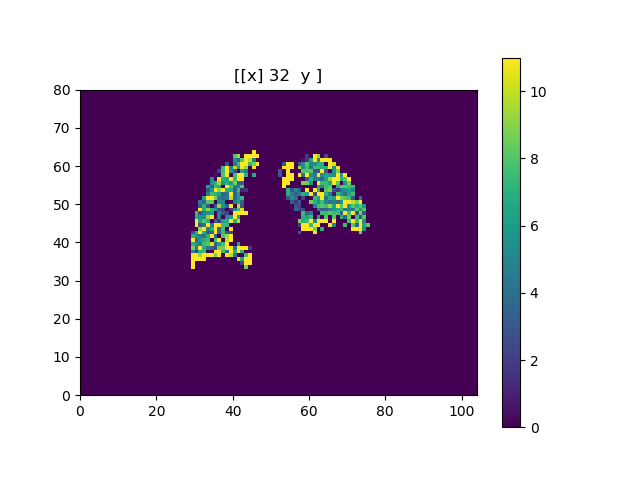

In [27]:
#Plot time to peak of the registered mask
pl.ImagePlot(time_to_peak_third_degree_poly_2, x=0, y=2, colormap ='viridis')

In [28]:
#Calculate time to peak with 3rd degree polynomial for registered lung mask
# time_to_peak_third_degree_poly_1 = calculate_time_to_peak_third_degree_poly(registered_mask)

In [29]:
#Plot time to peak of the registered mask
# pl.ImagePlot(time_to_peak_third_degree_poly_1, x=0, y=2, colormap ='viridis')

<h1> Time to Peak with 4th Degree Polynomial Curve Fitting <h1>

In [30]:
#Plot intensity with 4th degree polyonimal curve fit
def plot_fourth_degree_poly_curve_fit(intensity_values):
    poly_x, poly_y = fourth_degree_poly_curve_fitting(intensity_values, 80)
    fig = plt.figure()
    #Calculate TTP marker 
    ttp_marker_x = poly_x[np.argmax(poly_y)]
    ttp_marker_y = max(poly_y)
    plt.plot(np.arange(12), intensity_values, 'o', label='Intensity')
    plt.plot(poly_x, poly_y, label='4th Degree Polynomial')
    plt.plot(ttp_marker_x, ttp_marker_y, "x", label='Max')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [31]:
#Computes 4th degree polynomial values in [0,11]
def fourth_degree_poly_curve_fitting(y_values, samples):
    x_axis = np.linspace(0,11,12)
    poly_x_axis = np.linspace(0,11,num=samples)    
    poly_fit_function = np.poly1d(np.polyfit(x_axis, y_values, 4))
    
    return poly_x_axis, poly_fit_function(poly_x_axis)

In [32]:
#Calculates time to peak for 4th degree polynomial curve fitting
def calculate_time_to_peak_fourth_degree_poly(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))
    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    data = img[i, j, k, :]
                    fitted_x, fitted_y = fourth_degree_poly_curve_fitting(data, 20)

                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

In [33]:
#Calculate time to peak with 4th degree polynomial for a 4 voxel sample
time_to_peak_fourth_degree_poly_4 = calculate_time_to_peak_fourth_degree_poly(voxel_sample_4)

<IPython.core.display.Javascript object>


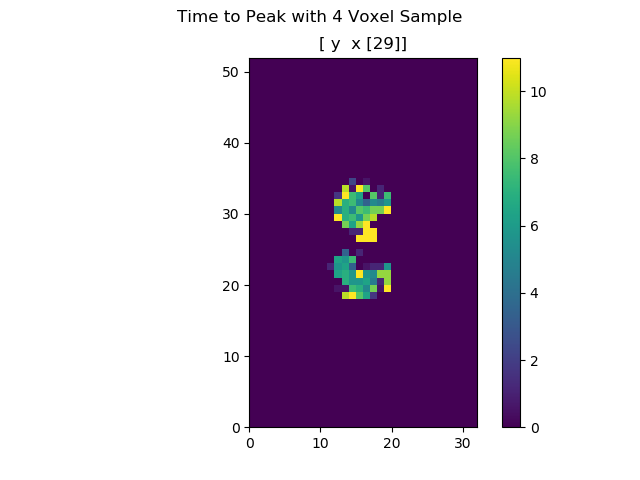

In [34]:
#Plot time to peak of a 4 voxel sample
pl.ImagePlot(time_to_peak_fourth_degree_poly_4, x=0, y=2, colormap ='viridis', title='Time to Peak with 4 Voxel Sample')

<IPython.core.display.Javascript object>


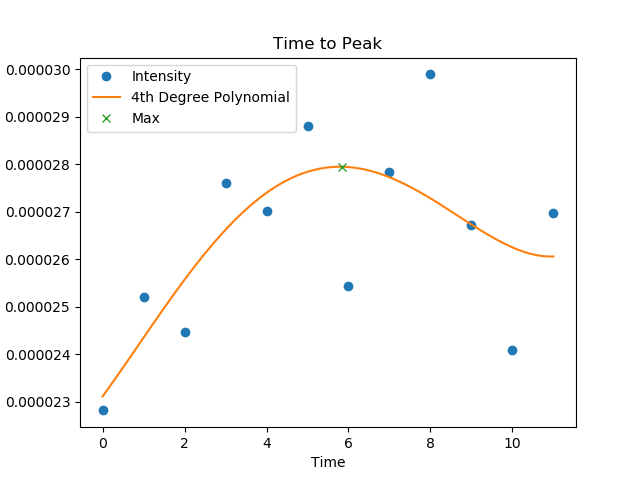

In [35]:
#Sample in the top of the left lung
plot_fourth_degree_poly_curve_fit(voxel_sample_4[20,16,28,:])

<IPython.core.display.Javascript object>


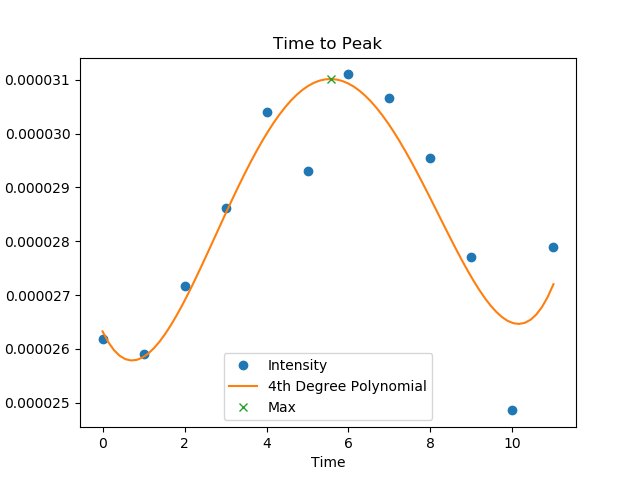

In [36]:
#Sample in the bottom of the left lung
plot_fourth_degree_poly_curve_fit(voxel_sample_4[16,16,20,:])

<IPython.core.display.Javascript object>


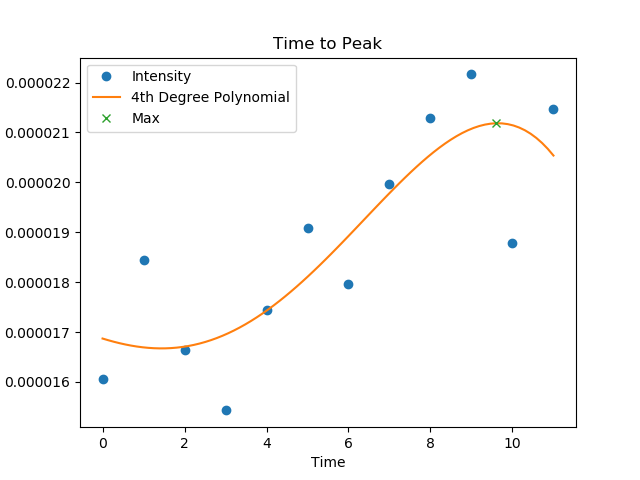

In [37]:
plot_fourth_degree_poly_curve_fit(voxel_sample_4[16,16,18,:])

In [38]:
#Calculate time to peak with 4th degree polynomial for registered lung mask
time_to_peak_fourth_degree_poly_2 = calculate_time_to_peak_fourth_degree_poly(voxel_sample_2)

<IPython.core.display.Javascript object>


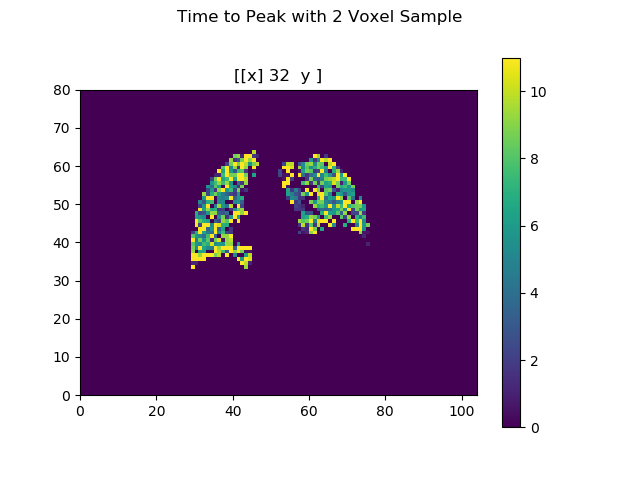

In [39]:
#Plot time to peak of the registered mask
pl.ImagePlot(time_to_peak_fourth_degree_poly_2, x=0, y=2, colormap ='viridis', title='Time to Peak with 2 Voxel Sample')

In [40]:
#Calculate time to peak with 4th degree polynomial for registered lung mask
# time_to_peak_fourth_degree_poly_1 = calculate_time_to_peak_fourth_degree_poly(registered_mask)

In [41]:
#Plot time to peak of the registered mask
# pl.ImagePlot(time_to_peak_fourth_degree_poly_1, x=0, y=2, colormap ='viridis')